In [2]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

class FileCollector:
    def collect(self, InputPath, Postfix):
        Files = []
        for root, dirs, files in os.walk(InputPath):
            for file in files:
                if file.endswith(Postfix):
                    Files.append(root + '/' + file)
        print("Collect {} files".format(len(Files)))
        return Files

class BenchmarkDictListsGen:
    """
    Return format:
    BenchmarksInfo = {"name": {"set": [...] , "cpu-cycles": [number], "func":{"func_name":[usage]} }}
    """
    def genFullInfo(self, Files):
        BenchmarksInfo = {}
        # Read files into list
        AllLines = []
        for file in Files:
            with open(file, 'r') as stream:
                for line in stream:
                    lineList = line.split(';')
                    AllLines.append(lineList)
                stream.close()
        # dict with benchmark name as keys
        '''
        line example: "name"; set | series_number ; cpu-cycles | number; func | name | usage; ...
        The value in DictContainerList = ["func"] will use dict as its container instead of list
        '''
        DictContainerList = ["func"]
        for lineInfo in AllLines:
            # if the key not exist, create the entry
            benchmarkName = lineInfo[0].strip()
            if benchmarkName not in BenchmarksInfo:
                BenchmarksInfo[benchmarkName] = {}
            # extract info in line, and skip those cannot split with "|" as key.
            for singleInfo in lineInfo:
                splitSingleinfo = singleInfo.split('|')
                if len(splitSingleinfo) < 2:
                    continue
                #ex. subKey = "set", "cpu-cycles", "func"
                subKey = splitSingleinfo[0].strip()
                if subKey in  DictContainerList:
                    UseDictContainer = True
                else:
                    UseDictContainer = False
                if BenchmarksInfo[benchmarkName].get(subKey) is None:
                    if UseDictContainer:
                        BenchmarksInfo[benchmarkName][subKey] = {}
                    else:
                        BenchmarksInfo[benchmarkName][subKey] = []
                if UseDictContainer == False:
                    if splitSingleinfo[1].strip() != "Error":
                        BenchmarksInfo[benchmarkName][subKey].append(splitSingleinfo[1].strip())
                else:
                    # Currently, only extract func usage
                    SubSubKey = splitSingleinfo[1].strip()
                    if BenchmarksInfo[benchmarkName][subKey].get(SubSubKey) is None:
                        BenchmarksInfo[benchmarkName][subKey][SubSubKey] = []
                    BenchmarksInfo[benchmarkName][subKey][SubSubKey].append(splitSingleinfo[2].strip())
        return BenchmarksInfo
    
    """
    Return Format: A dict
    {"benchmark name":["best-cpu-cycles value", "worst-cpu-cycles value", "best-set"]}
    Input:
    1. BenchmarksInfo = genFullInfo()'s return value
    2&3. target keys in "BenchmarksInfo"
    4. Whether the SetKey is meaningful
    """
    def genBestWorstAndPassSetDict(self, BenchmarksInfo, CycleKey, SetKey, SetAvability=True):
        retDict = {}
        tmp = {}
        '''
        Create dict-list from FullInfo and sort with cycle
        '''
        for benchmark in BenchmarksInfo.keys():
            cycleList = list(map(int, BenchmarksInfo[benchmark][CycleKey]))
            if not SetAvability:
                # This just make the set list has the same length as cycles
                setList = BenchmarksInfo[benchmark][CycleKey]
            else:
                setList = BenchmarksInfo[benchmark][SetKey]
            zipped = zip(cycleList, setList)
            benchmarkListOfList = [list(a) for a in zipped]
            tmp[benchmark] = sorted(benchmarkListOfList, key=itemgetter(0))
            
        '''
        Pack as the return dict
        '''
        for benchmark in tmp.keys():
            best_cycle = tmp[benchmark][0][0]
            if not SetAvability:
                best_set = "SetNotAvailable"
            else:
                best_set = tmp[benchmark][0][1]
            worst_cycle = tmp[benchmark][-1][0]
            retDict[benchmark] = [best_cycle, worst_cycle, best_set]
        return retDict
    """
    Write to file for Random-FunctionLevel use.
    Input: 
    1. output path
    2. return value from genBestWorstAndPassSetDict()
    """
    def WriteBenchmarkWithBestSet(self, path, Dict):
        with open(path, 'w') as file:
            for key, val in Dict.items():
                file.write("{}; best-set | {}\n".format(key, val[2]))
            file.close()
    
    """
    Return Format: A dict
    {"benchmark name":["normalized best-cpu-cycles speedup", "normalized worst-cpu-cycles speedup", "best-set"]}
    Input:
    1. From genBestWorstAndPassSetDict()'s return value
    2. From genCycleStdDeviation()'s first return value
    """
    def genNormalizedBestWorstAndPassSetDict(self, RandomBestWorstAndPassSetDict, StdMeanAndSigmaDict):
        retDict = {}
        for benchmarkName, benchmarkRecord in RandomBestWorstAndPassSetDict.items():
            BestSpeedup = StdMeanAndSigmaDict[benchmarkName]["cpu-cycles-mean"] / benchmarkRecord[0]
            WorstSpeedup = StdMeanAndSigmaDict[benchmarkName]["cpu-cycles-mean"] / benchmarkRecord[1]
            bestSet = benchmarkRecord[2]
            retDict[benchmarkName] = [BestSpeedup, WorstSpeedup, bestSet]
        return retDict
        
    
    """
    Return Format: As same as genFullInfo()
    Input:
    1. BenchmarksInfo = genFullInfo()'s return value
    2. SortedSigmaList = genCycleStdDeviation()'s second return value
    """
    def stripSignificantSigmaWithFullInfo(self, BenchmarksInfo, SortedSigmaList, Percentage, RecordLoc):
        totalCount = len(SortedSigmaList)
        rmCount = int(Percentage*totalCount)
        file = open(RecordLoc, 'w')
        for benchmark in SortedSigmaList[-rmCount:]:
            name = benchmark[0]
            BenchmarksInfo.pop(name)
            file.write("{}; cpu-cycles-sigma | {}\n".format(name, benchmark[1]))
        file.close()
        return BenchmarksInfo
    
    """
    Input: Use genFullInfo() to get the input
    Return Value: 
    1.  {"name":{"cpu-cycles-mean": num1, "cpu-cycles-sigma": num2}}
    2.  [["name", stddev]] sorted with stddev increasingly
    """
    def genCycleStdDeviation(self, FullInfo):
        retDict = {key: {} for key in list(FullInfo.keys())}
        retList = []
        for benchmarkName, BenchmarkDict in FullInfo.items():
            # Convert string to int
            intResults = list(map(int, BenchmarkDict["cpu-cycles"]))
            mean = statistics.mean(intResults)
            # Normalized with its average
            normResults = [cycle/mean for cycle in intResults]
            normSigma = statistics.stdev(normResults)
            retList.append([benchmarkName, normSigma])
            # Record original value in dict
            origSigma = statistics.stdev(intResults)
            retDict[benchmarkName]["cpu-cycles-mean"] = int(mean)
            retDict[benchmarkName]["cpu-cycles-sigma"] = int(origSigma)
        retList = sorted(retList, key = itemgetter(1))
        return retDict, retList
    
    """
    No Return Value.
    Input:
    1. First return value from genCycleStdDeviation()
    
    Record Format:
    "name"; Mean-cpu-cycles | number; Sigma-cpu-cycles | number 
    """
    def RecordMeasurableBenchmarks(self, MeanAndSigmaDict, OutputPath):
        file = open(OutputPath, "w")
        for Name, Dict in MeanAndSigmaDict.items():
            file.write("{}; cpu-cycles-mean | {}; cpu-cycles-sigma | {}\n".format(
                Name, Dict["cpu-cycles-mean"], Dict["cpu-cycles-sigma"]))
        file.close()
            


class GraphDrawer:
    OutputLoc = "./output/"
    """
    Input: InputDict from genCycleStdDeviation()
    """
    def DrawLineChartWithError(self, Title, InputDict, meanKey, sigmaKey):
        x = range(1, len(InputDict.keys())+1)
        y = []
        # twice sigma is about 95% of the data
        symmetricError= []
        '''
        Use InputDict to create a list of mean and sigma with meanKey.
        Sorted with mean decreasingly
        '''
        MeanWithSigma = []
        for key, value in InputDict.items():
            MeanWithSigma.append([value[meanKey], value[sigmaKey]])
        MeanWithSigma = sorted(MeanWithSigma, key = itemgetter(0), reverse=True)
        for Tuple in MeanWithSigma:
            y.append(Tuple[0])
            symmetricError.append(Tuple[1]*2)
        # Split into three line chart
        splitCount = 3
        step = len(x) // splitCount
        plt.rc('font', size=3.5)
        fig = plt.figure(dpi=600)
        fig.suptitle(Title, fontweight='bold', fontsize=11, y=1.03)
        mean_patch = mpatches.Patch(color='yellow', label='Mean of cpu-cycles with perf')
        sigma_patch = mpatches.Patch(color='black', label='Twice Sigma of cpu-cycles with perf')
        for i in range(splitCount):
            ax = fig.add_subplot(3,1,i+1)
            ax.set_ylabel('cpu-cycles, scale at left-top corner')
            ax.set_xlabel('benchmark number, sorted by mean cpu-cycles')
            indexStart = i*step
            indexEnd = (i+1)*step
            ax.errorbar(x[indexStart:indexEnd], y[indexStart:indexEnd], yerr=symmetricError[indexStart:indexEnd]
                        , fmt='-', ecolor='black', capsize=1.5,  linewidth=0.75, color='yellow')
            plt.legend(handles=[mean_patch, sigma_patch])
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')
        
    # Helper method
    def GraphGenerator_AutoLabel(self, rects, ax, location):
        horizontalAlign = 'center'
        if location == "up":
            verticalAlign='bottom'
        else:
            verticalAlign='top'

        for rect in rects:
            h = rect.get_height()
            label = "%.2f" % (h)
            if location == "up":
                h = h*1.0
            else:
                h = h*1.0
            ax.text(rect.get_x()+rect.get_width()/2., h, label,
                    ha=horizontalAlign, va=verticalAlign)
    """
    Input:
    1. Title name
    2. and 3. are Second return value from genCycleStdDeviation()
    """
    def DrawSigmaComparsion(self, Title, SingleCoreSortedSigmaList, MultiCoreSortedSigmaList):
        '''
        Prepare the chart input
        '''
        x = []
        y1 = []
        y2 = []
        tmp = []
        for SingleCoreBnechmark in SingleCoreSortedSigmaList:
            x.append(SingleCoreBnechmark[0])
            y1.append(SingleCoreBnechmark[1])
        for MultiCoreBnechmark in MultiCoreSortedSigmaList:
            name = MultiCoreBnechmark[0]
            if name in x:
                y2.append(MultiCoreBnechmark[1])
        '''Draw'''
        plt.rc('font', size=2.5)
        fig = plt.figure(dpi=600)
        width = 0.27 # the width of the barspass
        
        # Split into two bar chart
        splitCount = 2
        step = len(x) // splitCount
        SingleCore_patch = mpatches.Patch(color='yellow', label='Normalized SingleCore Standard Deviation')
        MultiCore_patch = mpatches.Patch(color='green', label='Normalized MultiCore Standard Deviation')
        for i in range(splitCount):
            indexStart = i*step
            indexEnd = (i+1)*step
            x_sub = x[indexStart:indexEnd]
            y1_sub = y1[indexStart:indexEnd]
            y2_sub = y2[indexStart:indexEnd]
            ax = fig.add_subplot(splitCount, 1 , i+1)
            index = np.arange(len(x_sub))
            rects1 = ax.bar(index, y1_sub, width, color='yellow')
            rects2 = ax.bar(index + width, y2_sub, width, color='green')
            self.GraphGenerator_AutoLabel(rects1, ax, "up")
            #self.GraphGenerator_AutoLabel(rects2, ax, "down")
            self.GraphGenerator_AutoLabel(rects2, ax, "up")
            ax.set_ylabel('Normalized Standard Deviation Single/Multi-Core Comparision With Standard Clang-5.0')
            ax.set_xticks(index + width)
            ax.set_xticklabels(x_sub, rotation=90)
            plt.legend(handles=[SingleCore_patch, MultiCore_patch])
        
        fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.01)
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')
        
    """
    Input: From genNormalizedBestWorstAndPassSetDict()'s return value
    """
    def DrawRandomBenchmarkLevelSpeedup(self, RandomNormalizedBestWorstAndPassSetDict, Title):
        benchmarkListOfList = []
        for benchmarkName, benchmarkList in RandomNormalizedBestWorstAndPassSetDict.items():
            benchmarkListOfList.append([benchmarkName, benchmarkList[0], benchmarkList[1], benchmarkList[2]])
        # Sort from fast to slow with best speedup
        benchmarkListOfList = sorted(benchmarkListOfList, key=itemgetter(1), reverse=True)
        '''
        Prepare chart input
        '''
        NameList = []
        NormBestList = []
        NormWorstList = []
        BestSetList = []
        for benchmark in benchmarkListOfList:
            NameList.append(benchmark[0])
            '''
            Note:
            We do not want the graph to be hard to read.
            You may nend to modify the number exceed 3 by yourself.
            '''
            #In our case, we reduce 897.66 to 4.
            if benchmark[1] > 4:
                NormBestList.append(4)
            else:
                NormBestList.append(benchmark[1])
            NormWorstList.append(benchmark[2])
            BestSetList.append(benchmark[3])
        
        '''
        Record to file
        '''
        with open("./output/BenchmarkLevel-BestSpeedupWithPassSet-GraphRecord", "w") as file:
            for benchmark in benchmarkListOfList:
                msg = "{}; norm-best-speedup-cpu-cycles | {}; norm-worst-speedup-cpu-cycles | {}; best-PassSet | {}\n".format(
                    benchmark[0], benchmark[1], benchmark[2], benchmark[3])
                file.write(msg)
            file.close()
        x = NameList
        y1 = NormBestList
        y2 = NormWorstList
        '''
        Draw two-bar chart
        '''
        plt.rc('font', size=3)
        fig = plt.figure(dpi=600)
        width = 0.27 # the width of the barspass
        
        # Split into two bar chart
        splitCount = 3
        step = len(x) // splitCount
        patch_bestSpeedup = mpatches.Patch(color='red', label='Best Speedup in this benchmark')
        patch_worstSpeedup = mpatches.Patch(color='green', label='Worst Speedup in this benchmark')
        percentage = 0.05
        RealSplitCount = splitCount + 1
        for i in range(RealSplitCount):
            indexStart = i*step
            indexEnd = indexStart + int(percentage * len(x))
            '''
            Last sub-graph start from tail
            '''
            if i == (RealSplitCount - 1):
                indexEnd = len(x)
                indexStart = indexEnd - int(percentage * len(x))
            '''
            y label location
            '''
            if i == 0:
                y_label_loc = "up"
            else:
                y_label_loc = "down"
            '''
            Skip special case
            '''
            """
            if indexStart == 0:
                indexStart = 1
            """

            #x_subName = x[indexStart:indexEnd]
            x_sub = list(range(indexStart,indexEnd))
            for order in x_sub:
                print("Order={}, Benchmark=\"{}\", Set=\"{}\"".format(order, NameList[order], BestSetList[order]))
            y1_sub = y1[indexStart:indexEnd]
            y2_sub = y2[indexStart:indexEnd]
            ax = fig.add_subplot(RealSplitCount, 1 , i+1)
            index = np.arange(len(x_sub))
            rects1 = ax.bar(index, y1_sub, width, color='red')
            rects2 = ax.bar(index + width, y2_sub, width, color='green')
            self.GraphGenerator_AutoLabel(rects1, ax, y_label_loc)
            self.GraphGenerator_AutoLabel(rects2, ax, y_label_loc)
            XLength = len(x)
            ax.set_ylabel('Normalized Speedup Cpu-Cycles: {}% - {}%'.format(
                round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
            ax.set_xticks(index + width)
            ax.set_xticklabels(x_sub, rotation=0)
            
        fig.legend( (rects1[0], rects2[0]), ('Best Speedup in this benchmark', 'Worst Speedup in this benchmark') )
        fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.0)
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')
    

    """
    Input:Both are from genNormalizedBestWorstAndPassSetDict()'s return value
    The output graph is sorted with the red bar
    """
    def DrawFunctionLevelWithBenchmarkLevelCmp(self, BenchmarkLevelDict, FunctionLevelDict, Title):
        benchmarkListOfList = []
        for benchmarkName, benchmarkList in FunctionLevelDict.items():
            '''
            The input already normalized speedup, not time cost
            '''
            BenchmarkLevelBest = BenchmarkLevelDict[benchmarkName][0]
            bestVSbest = FunctionLevelDict[benchmarkName][0]/BenchmarkLevelBest
            worstVSbest = FunctionLevelDict[benchmarkName][1]/BenchmarkLevelBest
            benchmarkListOfList.append([benchmarkName, BenchmarkLevelBest, bestVSbest, worstVSbest])
        # Sort from fast to slow with best speedup
        benchmarkListOfList = sorted(benchmarkListOfList, key=itemgetter(2), reverse=True)
        '''
        Prepare chart input
        '''
        NameList = []
        BenchmarkLevelList = []
        NormBestList = []
        NormWorstList = []
        for benchmark in benchmarkListOfList:
            NameList.append(benchmark[0])
            BenchmarkLevelList.append(benchmark[1])
            NormBestList.append(benchmark[2])
            NormWorstList.append(benchmark[3])

        x = NameList
        y0 = BenchmarkLevelList
        y1 = NormBestList
        y2 = NormWorstList
        '''
        Draw two-bar chart
        '''
        plt.rc('font', size=3)
        fig = plt.figure(dpi=600)
        width = 0.20 # the width of the bars
        
        # Split into two bar chart
        splitCount = 2
        step = len(x) // splitCount
        patch_BenchmarkLevelSpeedup = mpatches.Patch(color='yellow',
                                                     label='Best B-L Speedup w.r.t Std.')
        patch_bestSpeedup = mpatches.Patch(color='red', 
                                           label='Best F-L Speedup w.r.t B-L')
        patch_worstSpeedup = mpatches.Patch(color='green', 
                                            label='Worst F-L Speedup w.r.t B-L')
        percentage = 0.10
        RealSplitCount = splitCount + 1
        for i in range(RealSplitCount):
            indexStart = i*step
            indexEnd = indexStart + int(percentage * len(x))
            '''
            Last sub-graph start from tail
            '''
            if i == (RealSplitCount - 1):
                indexEnd = len(x)
                indexStart = indexEnd - int(percentage * len(x))

            x_sub = list(range(indexStart,indexEnd))
            for order in x_sub:
                print("Order={}, Benchmark=\"{}\"".format(order, NameList[order]))
            y0_sub = y0[indexStart:indexEnd]
            y1_sub = y1[indexStart:indexEnd]
            y2_sub = y2[indexStart:indexEnd]
            ax = fig.add_subplot(RealSplitCount, 1 , i+1)
            index = np.arange(len(x_sub))
            rects0 = ax.bar(index, y0_sub, width, color='yellow')
            rects1 = ax.bar(index + 1*width, y1_sub, width, color='red')
            rects2 = ax.bar(index + 2*width, y2_sub, width, color='green')
            y_label_loc = "up"
            self.GraphGenerator_AutoLabel(rects0, ax, y_label_loc)
            self.GraphGenerator_AutoLabel(rects1, ax, y_label_loc)
            self.GraphGenerator_AutoLabel(rects2, ax, y_label_loc)
            XLength = len(x)
            ax.set_ylabel('Best F-L Speedup w.r.t B-L Order: {}% - {}%'.format(
                round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
            ax.set_xticks(index + width)
            ax.set_xticklabels(x_sub, rotation=0)
            
        fig.legend( (rects0[0], rects1[0], rects2[0]), ('Best B-L Speedup w.r.t Std.',
                                                        'Best F-L Speedup w.r.t B-L',
                                                        'Worst F-L Speedup w.r.t B-L') )
        fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.03)
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')


Collect 100 files


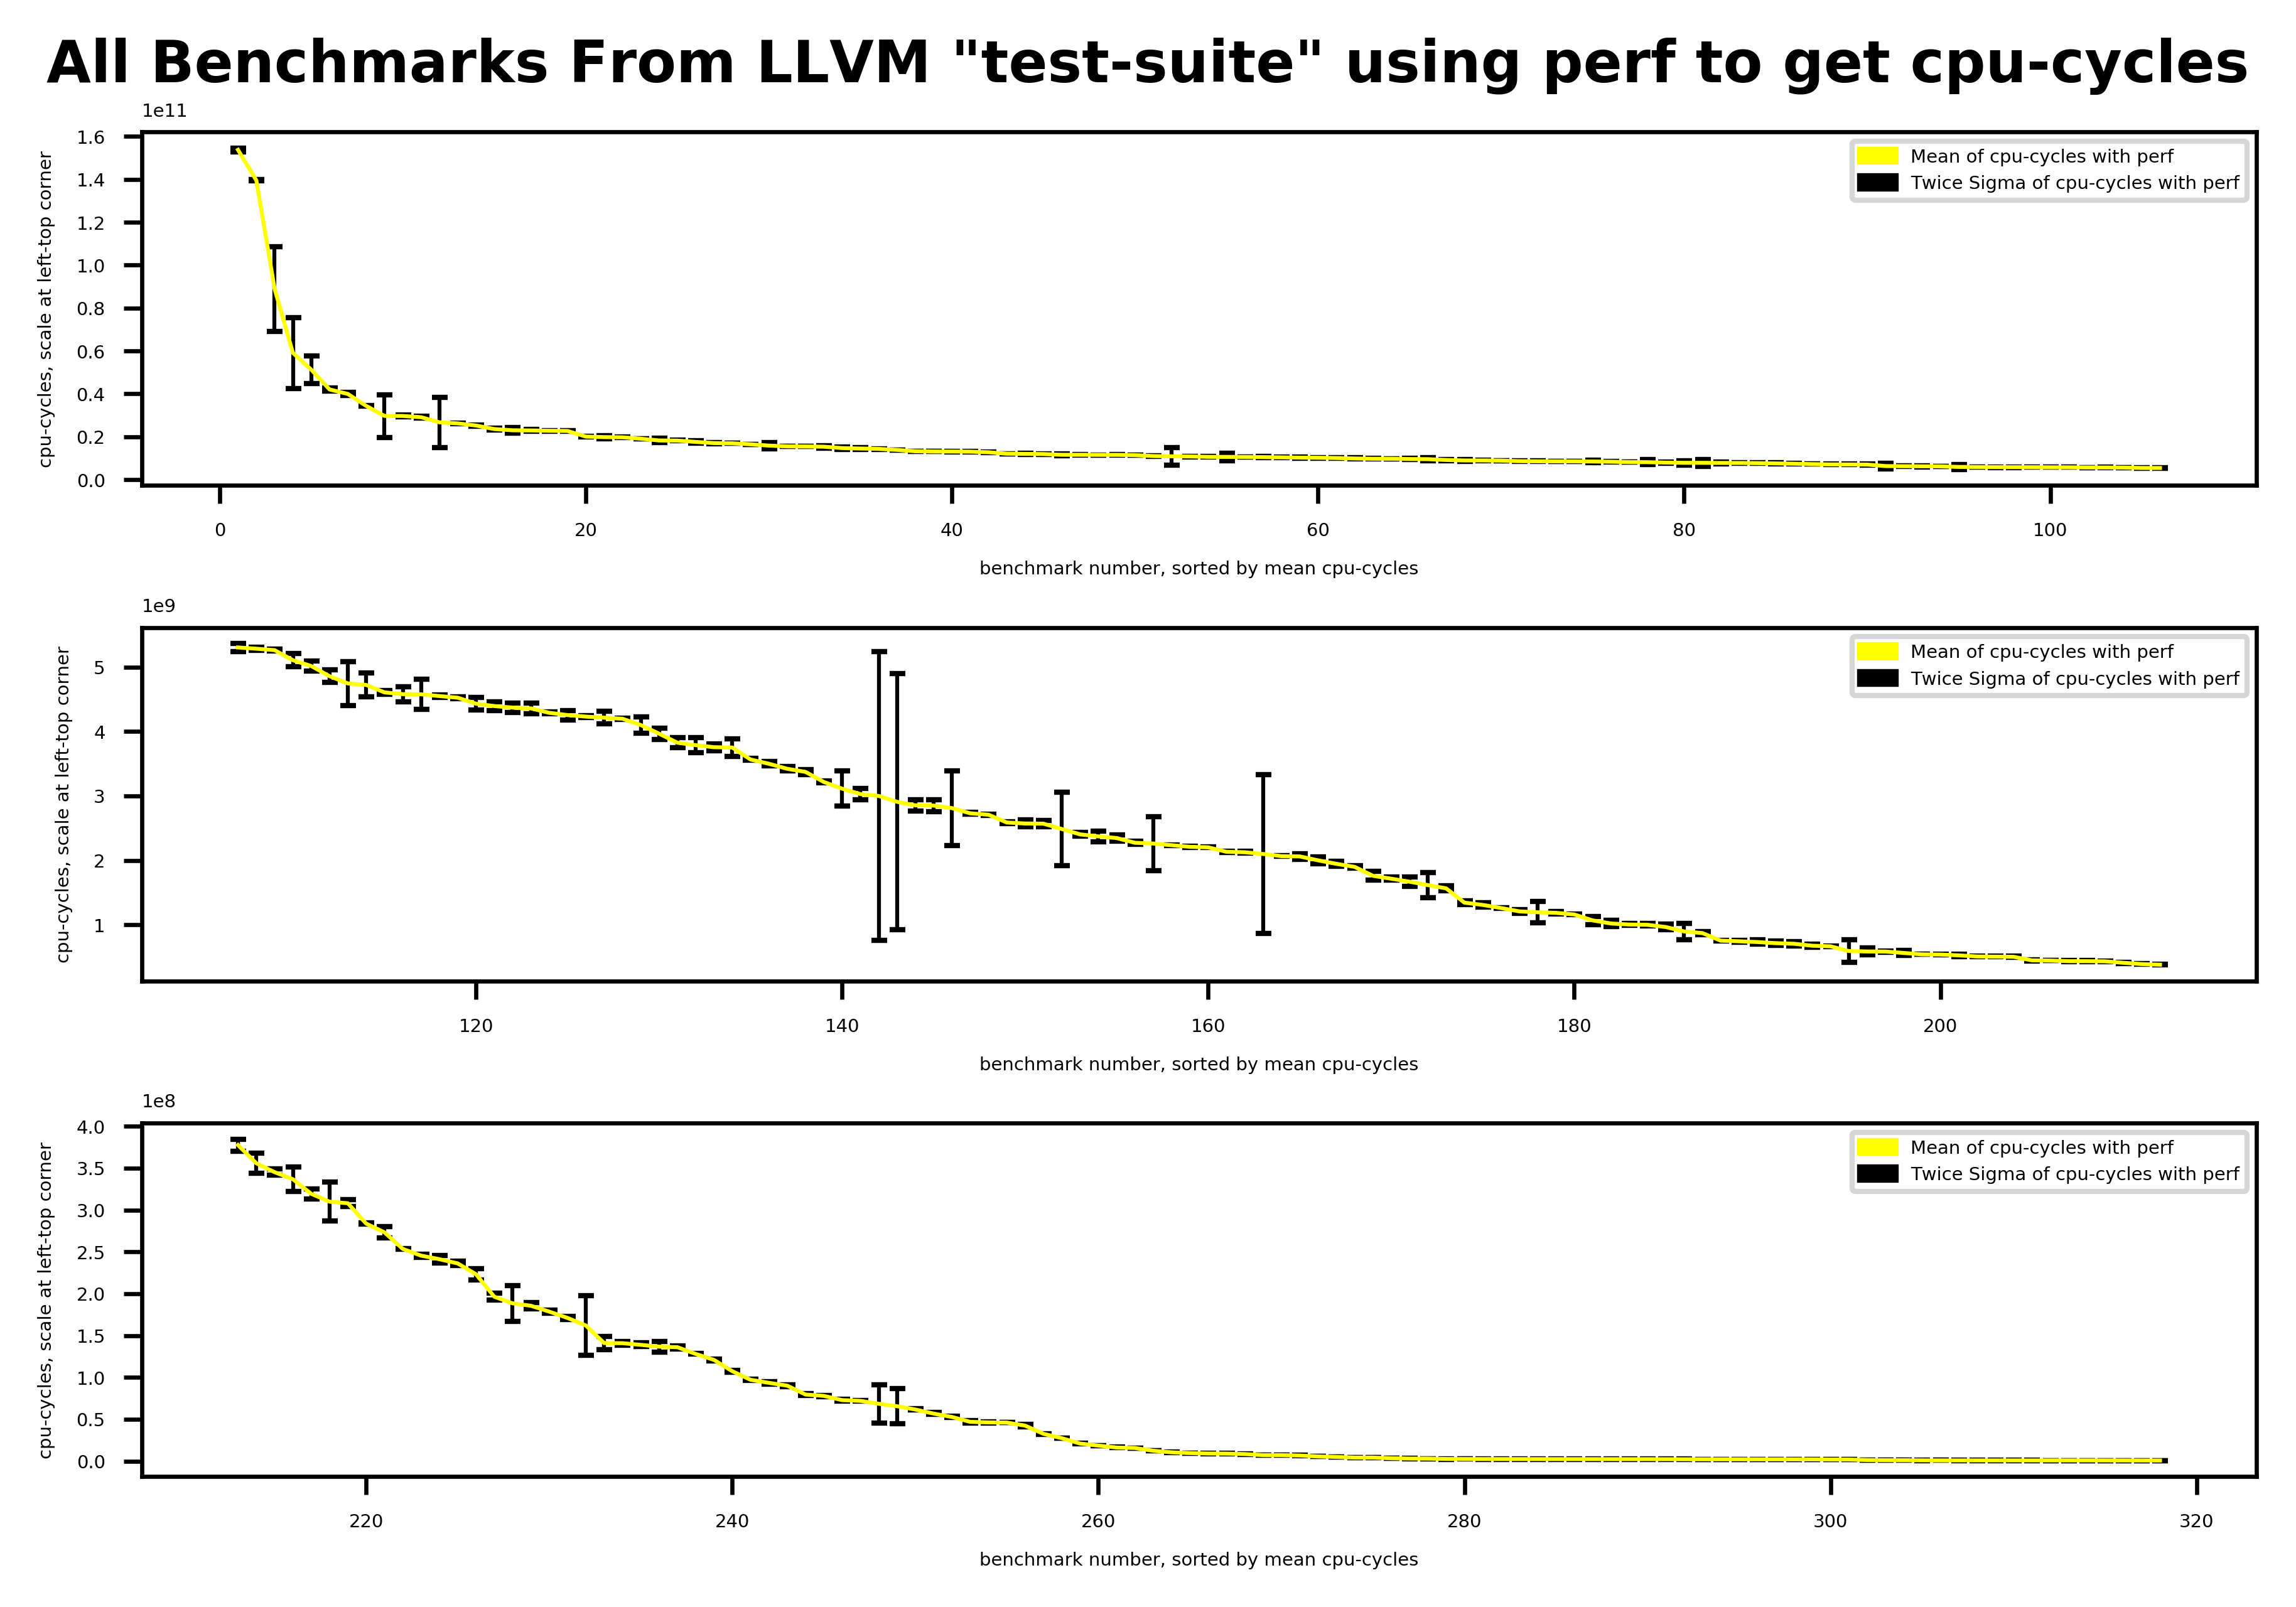

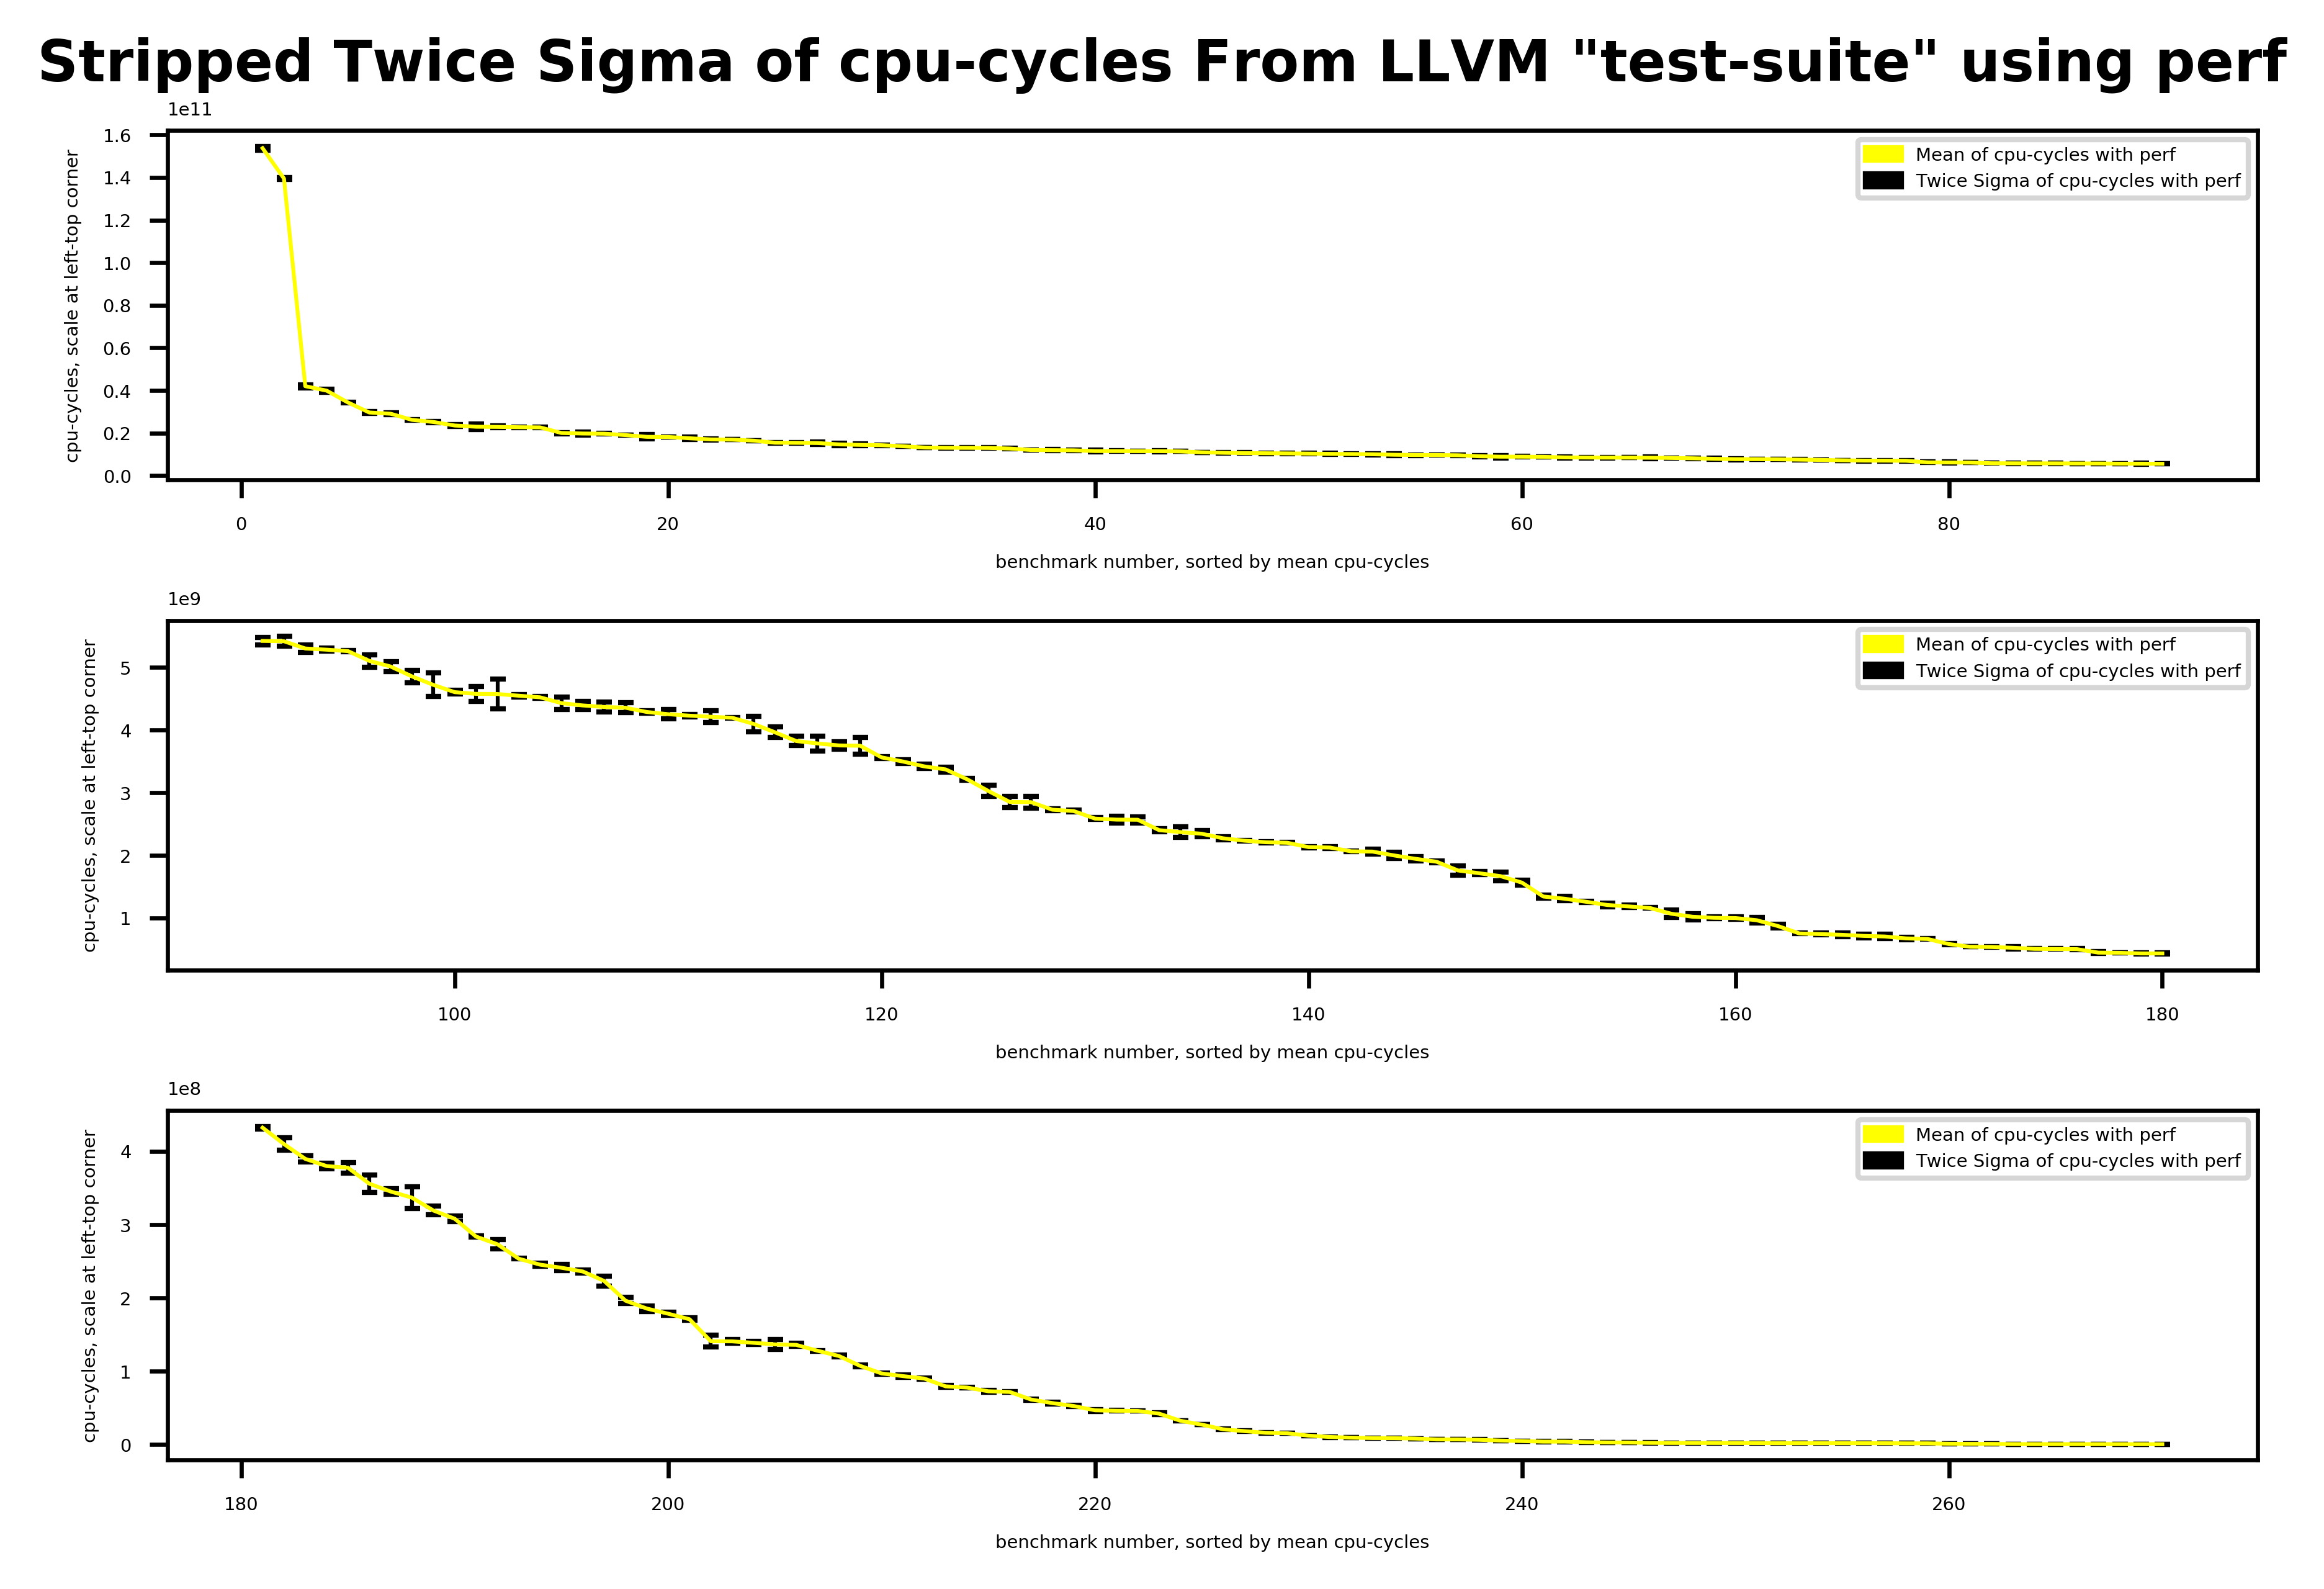

Done.


In [38]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all std files
    '''
    # Get input files
    Input = FileCollector()
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    # Get full info about the benchmarks
    benchmarks = BenchmarkDictListsGen()
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Draw the mean and sigma graph based on full info
    '''
    # Use FullInfo to generate standard deviation
    MeanAndSigmaDict, SortedSigmaList= benchmarks.genCycleStdDeviation(stdBenchmarks)
    # Use arranged data to draw graph
    drawer = GraphDrawer()
    drawer.DrawLineChartWithError("All Benchmarks From LLVM \"test-suite\" using perf to get cpu-cycles", 
                                  MeanAndSigmaDict, "cpu-cycles-mean", "cpu-cycles-sigma")
    '''
    Strip the full info based on mean and sigma 
    '''
    # Remove the benchmarks that their sigma affects too much
    # In our case, the sigma threshold = 3%
    stripStdBenchmarks = benchmarks.stripSignificantSigmaWithFullInfo(stdBenchmarks, SortedSigmaList, 0.15, "./output/RemovedStdBenchmarkSigma")
    '''
    Draw the mean and sigma graph based on the new full info
    '''
    # Use FullInfo to generate standard deviation
    MeanAndSigmaDict, SortedSigmaList= benchmarks.genCycleStdDeviation(stripStdBenchmarks)
    # Use arranged data to draw graph
    drawer.DrawLineChartWithError("Stripped Twice Sigma of cpu-cycles From LLVM \"test-suite\" using perf", 
                                  MeanAndSigmaDict, "cpu-cycles-mean", "cpu-cycles-sigma")
    '''
    Record the real measurable benchmarks
    '''
    benchmarks.RecordMeasurableBenchmarks(MeanAndSigmaDict, "./output/MeasurableStdBenchmarkMeanAndSigma")
    
    
    print("Done.")

Collect 100 files
Collect 100 files


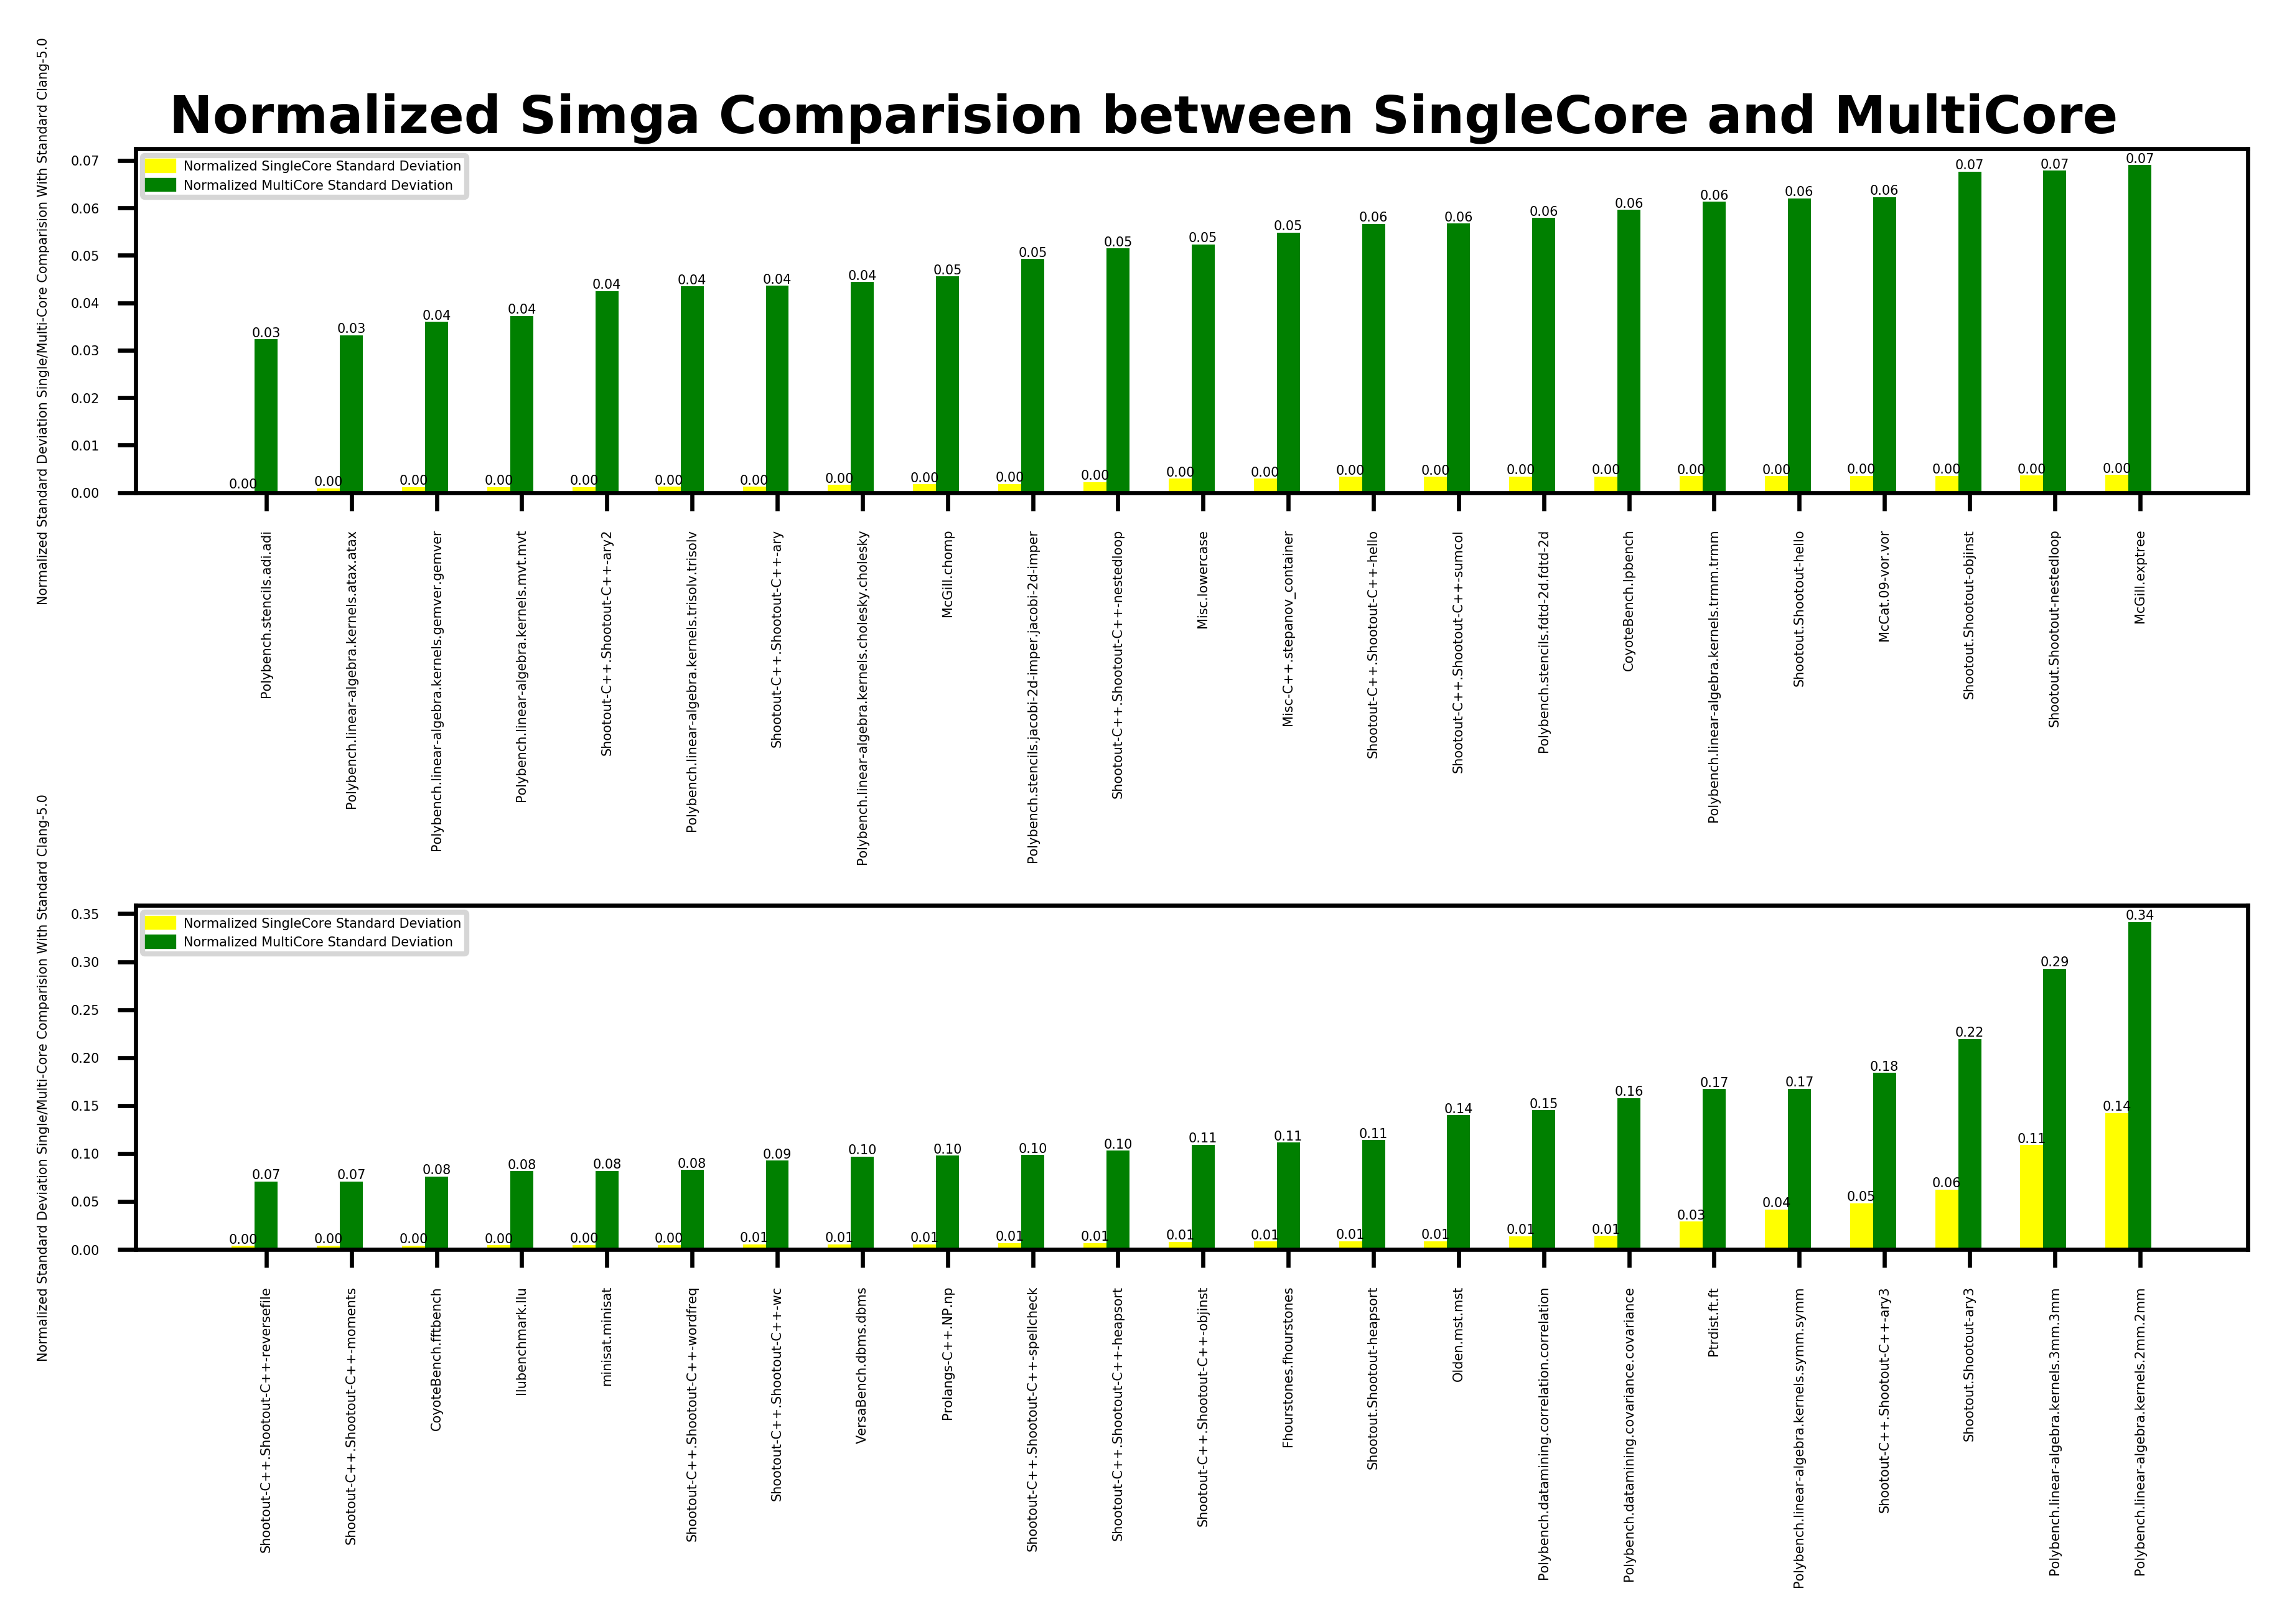

In [39]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all std files
    '''
    # Get input files
    Input = FileCollector()
    StdSimgaFiles = Input.collect("./input/SingleCoreSTD", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    # Get full info about the benchmarks
    benchmarks = BenchmarkDictListsGen()
    stdSigmaBenchmarks = benchmarks.genFullInfo(StdSimgaFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Draw the sigma graph based on full info
    '''
    # Use FullInfo to generate standard deviation
    SingleCoreMeanAndSigmaDict, SingleCoreSortedSigmaList= benchmarks.genCycleStdDeviation(stdSigmaBenchmarks)
    MultiCoreMeanAndSigmaDict, MultiCoreSortedSigmaList= benchmarks.genCycleStdDeviation(stdBenchmarks)
    # Use arranged data to draw graph
    drawer = GraphDrawer()
    drawer.DrawSigmaComparsion("Normalized Simga Comparision between SingleCore and MultiCore", 
                                  SingleCoreSortedSigmaList, MultiCoreSortedSigmaList)
    
    

Collect 108 files
Collect 100 files
Order=0, Benchmark="Misc.ffbench", Set="33 9 27 30 6 23 25 32 29 21 14 2 16 31 34 28 8 19 1"
Order=1, Benchmark="SIBsim4.SIBsim4", Set="27 28 23 17 32 7 10 3 18 20 29"
Order=2, Benchmark="Misc.flops-6", Set="2 29 32 9 16 11 21 4 30 27 5 3 23 10 7 22 26 13 14"
Order=3, Benchmark="Stanford.Puzzle", Set="15 33 29 7 6 21 27 17 22 14 18"
Order=4, Benchmark="Misc.flops-8", Set="22 4 34 25 29 14 28 18 15 31 12 21 8 24 30 7 5 32 10"
Order=5, Benchmark="Ptrdist.ks.ks", Set="33 30 27 19"
Order=6, Benchmark="Shootout-C++.Shootout-C++-ackermann", Set="7 5 29 2 27 23 1 15 14 3 19 20 32 10 6 30 25 4 17"
Order=7, Benchmark="Misc.himenobmtxpa", Set="34 2 13 9 23 3 21 33 17 14 25 11 12 7 31 1 15 19 16"
Order=8, Benchmark="Misc.perlin", Set="12 28 3 19 10 4 5 15 11 18 16 21 2 14 22 30 33 7 8"
Order=9, Benchmark="Polybench.linear-algebra.solvers.dynprog.dynprog", Set="34 2 13 9 23 3 21 33 17 14 25 11 12 7 31 1 15 19 16"
Order=10, Benchmark="Prolangs-C++.family.family",

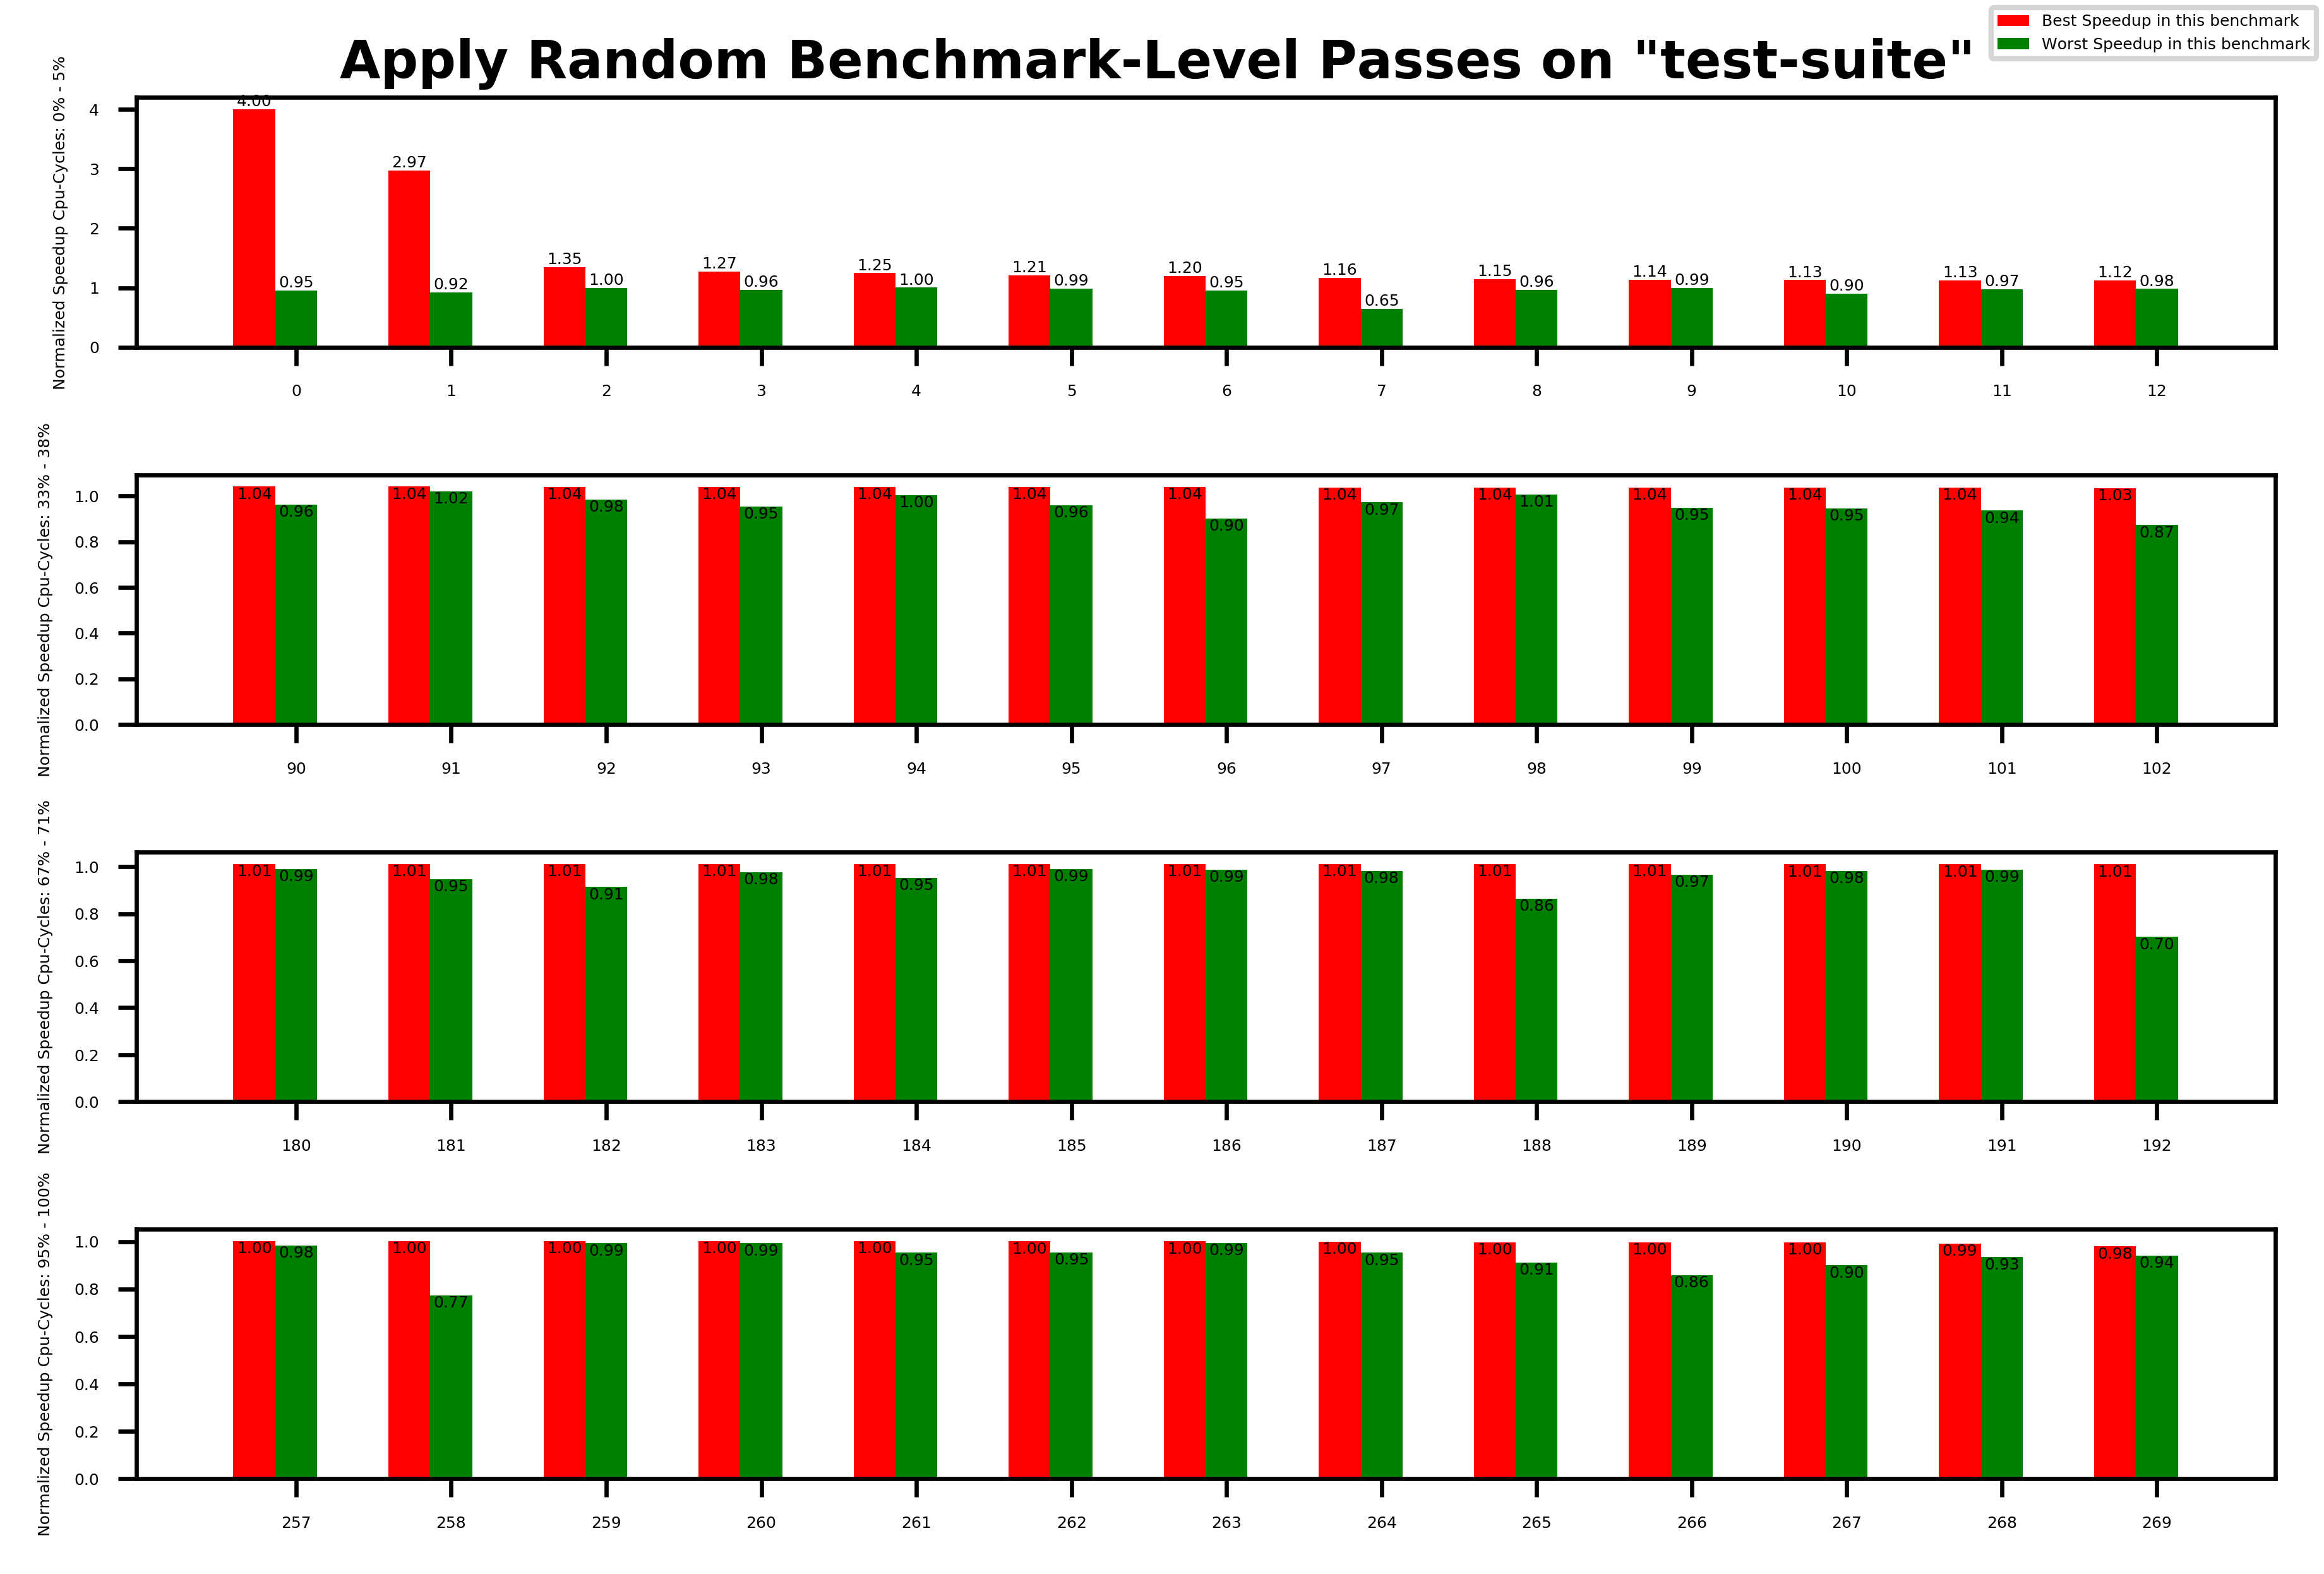

Done.


In [40]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all input files
    '''
    Input = FileCollector()
    RandomBenchmarkLevelFiles = Input.collect("./input/Random-BenchmarkLevel", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    benchmarks = BenchmarkDictListsGen()
    RandomBenchmarkLevelBenchmarks = benchmarks.genFullInfo(RandomBenchmarkLevelFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Gather the best and worst cpu-cycles and corresponding passes from the FullInfo
    '''
    RandomBestWorstAndPassSetDict = benchmarks.genBestWorstAndPassSetDict(RandomBenchmarkLevelBenchmarks,
                                                                          'cpu-cycles', 'set')
    '''
    Get mean Std cpu-cycles
    '''
    StdMeanAndSigmaDict, _ = benchmarks.genCycleStdDeviation(stdBenchmarks)
    '''
    Gather the normalized best and worst cpu-cycles
    '''
    RandomNormalizedBestWorstAndPassSetDict = benchmarks.genNormalizedBestWorstAndPassSetDict(
        RandomBestWorstAndPassSetDict, StdMeanAndSigmaDict)
    '''
    For Function-Level as input
    '''
    # Already done as "BenchmarkLevel-BestSpeedupWithPassSet-GraphRecord"
    #benchmarks.WriteBenchmarkWithBestSet("./output/Random-BenchmarkLevelWithBestSet", RandomNormalizedBestWorstAndPassSetDict)
    '''
    Draw the best with worst bar chart
    '''
    drawer = GraphDrawer()
    drawer.DrawRandomBenchmarkLevelSpeedup(RandomNormalizedBestWorstAndPassSetDict, 
                                           "Apply Random Benchmark-Level Passes on \"test-suite\"")

    print("Done.")
    


Collect 595 files
Collect 108 files
Collect 100 files
Order=0, Benchmark="TSVC.ControlLoops-flt.ControlLoops-flt"
Order=1, Benchmark="TSVC.Reductions-dbl.Reductions-dbl"
Order=2, Benchmark="SIBsim4.SIBsim4"
Order=3, Benchmark="FreeBench.pifft.pifft"
Order=4, Benchmark="PAQ8p.paq8p"
Order=5, Benchmark="McCat.18-imp.imp"
Order=6, Benchmark="Olden.bisort.bisort"
Order=39, Benchmark="sgefa.sgefa"
Order=40, Benchmark="d.make_dparser"
Order=41, Benchmark="mediabench.g721.g721encode.encode"
Order=42, Benchmark="7zip.7zip-benchmark"
Order=43, Benchmark="McCat.08-main.main"
Order=44, Benchmark="VersaBench.ecbdes.ecbdes"
Order=45, Benchmark="Adobe-C++.stepanov_vector"
Order=71, Benchmark="Adobe-C++.stepanov_abstraction"
Order=72, Benchmark="TSVC.LoopRerolling-dbl.LoopRerolling-dbl"
Order=73, Benchmark="mediabench.mpeg2.mpeg2dec.mpeg2decode"
Order=74, Benchmark="hexxagon.hexxagon"
Order=75, Benchmark="TSVC.GlobalDataFlow-flt.GlobalDataFlow-flt"
Order=76, Benchmark="siod.siod"
Order=77, Benchmark=

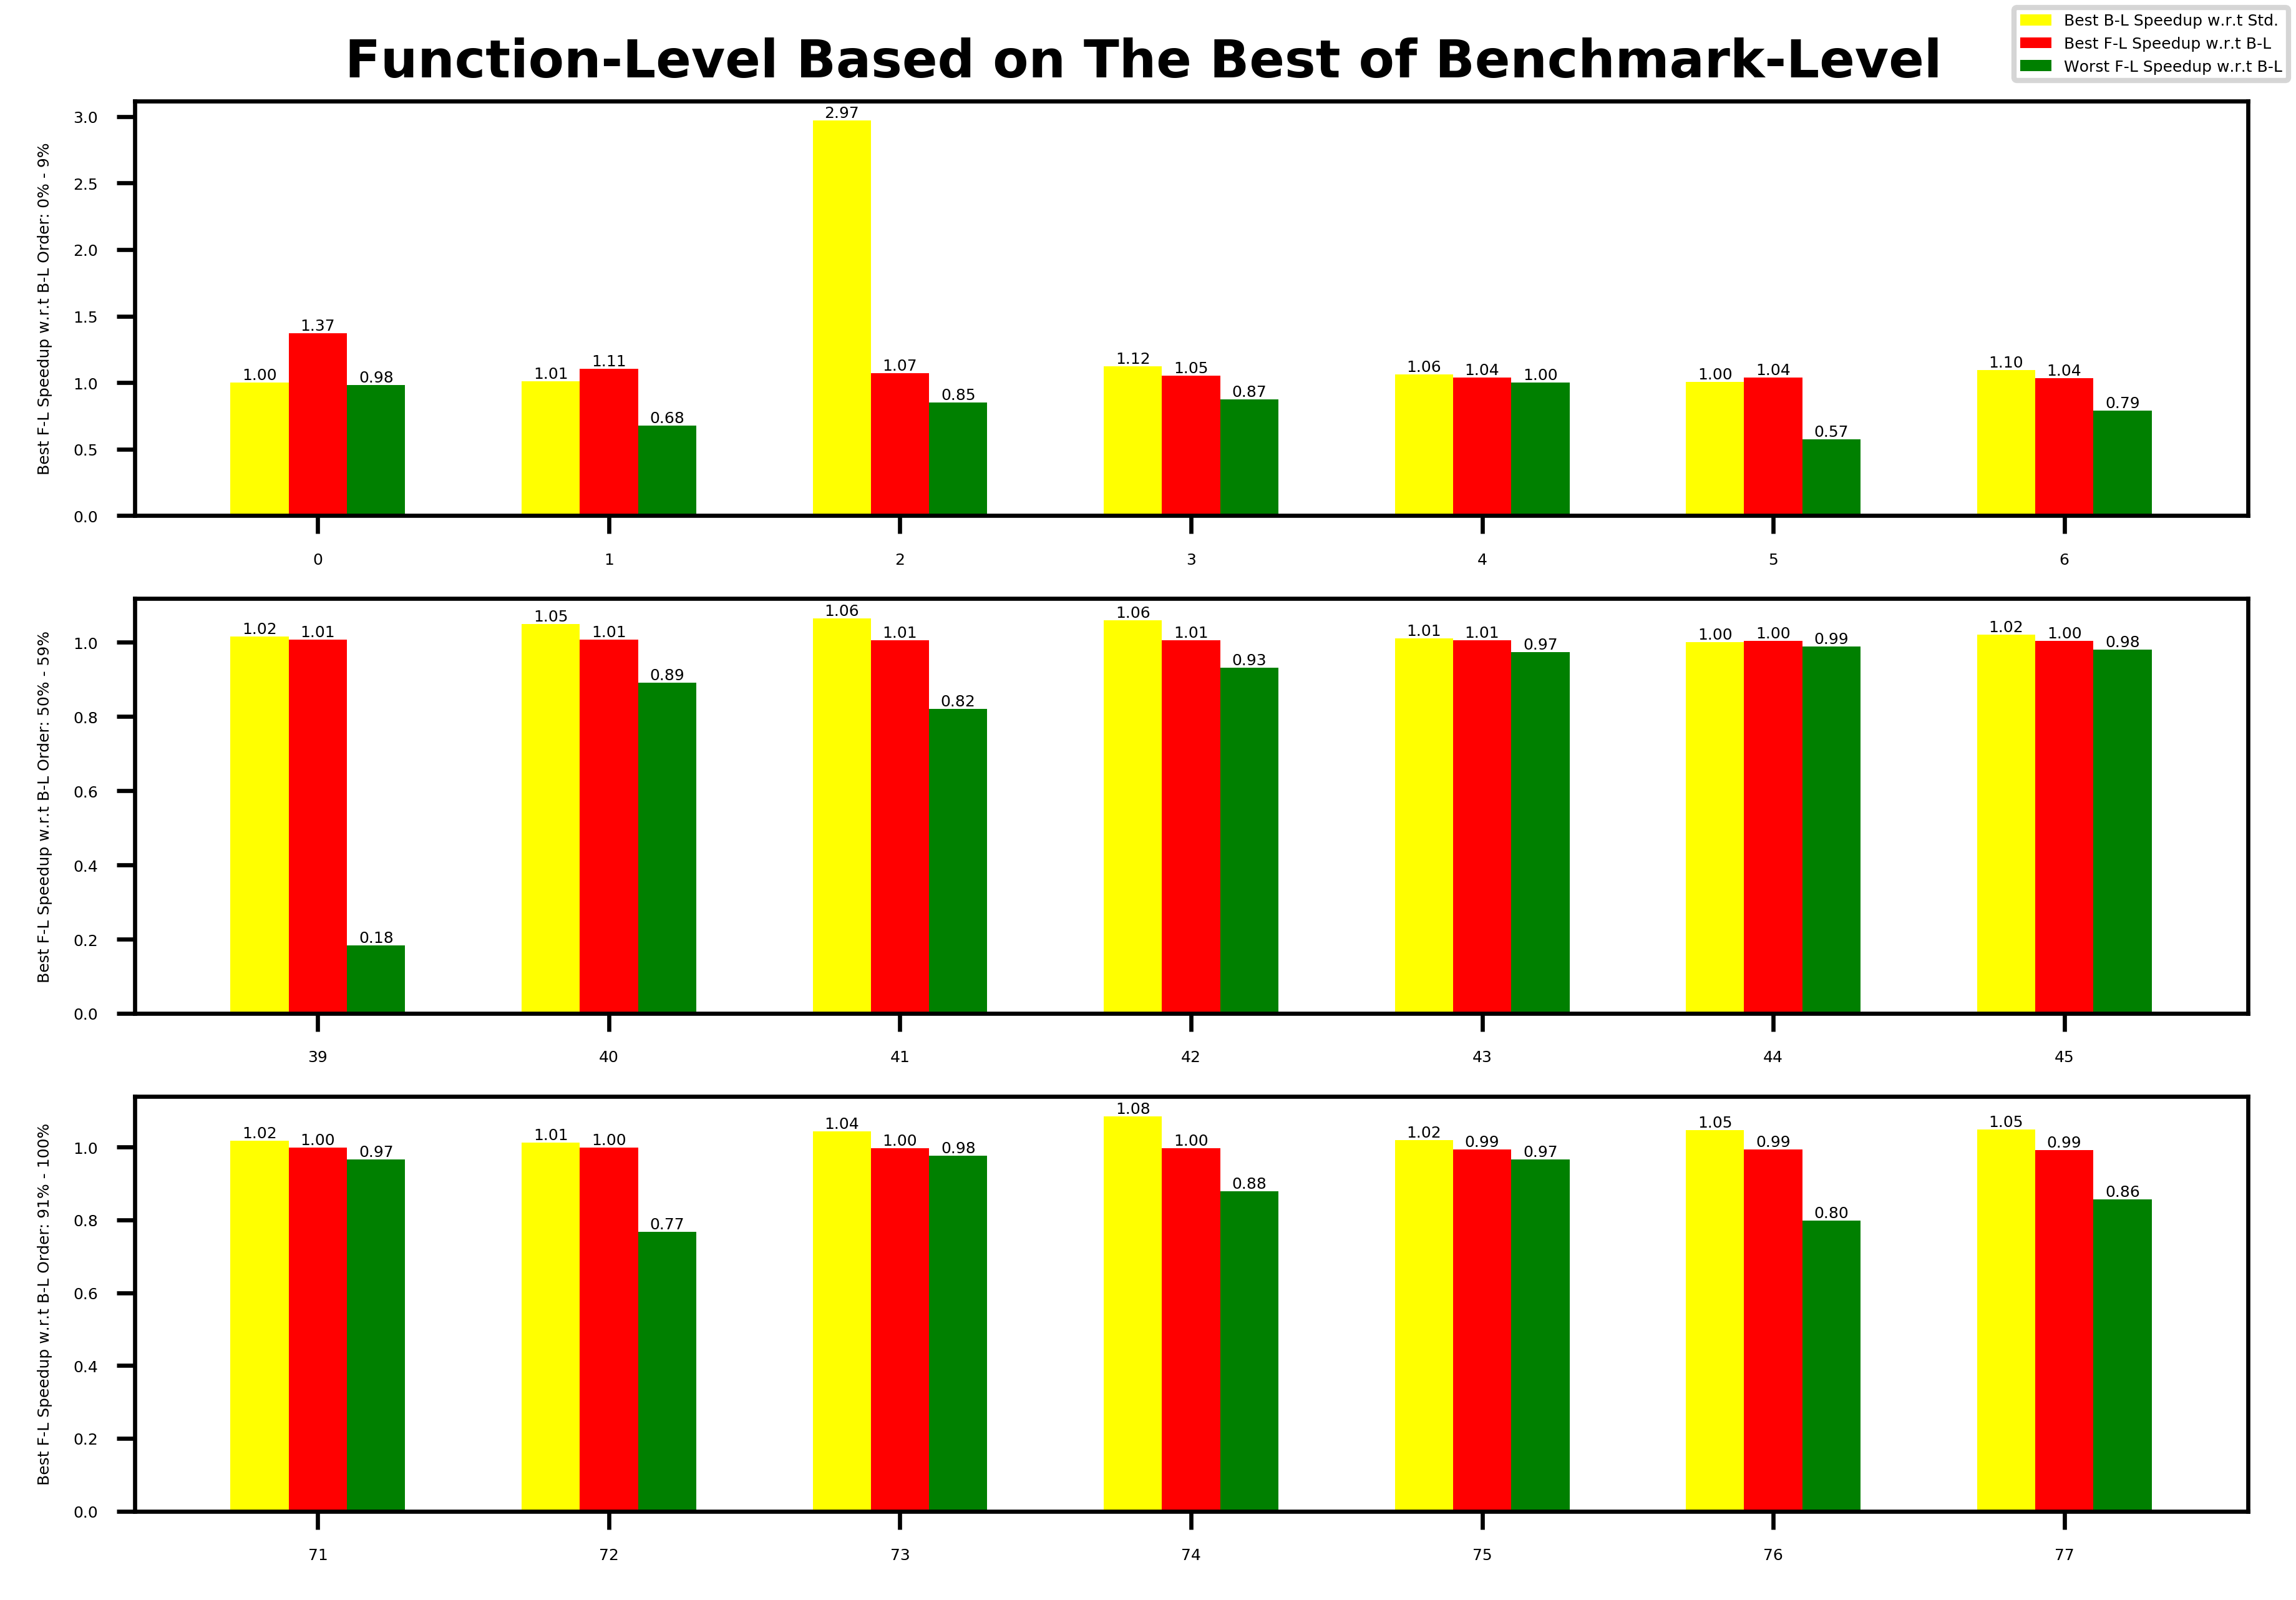

Done.


In [3]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all input files
    '''
    Input = FileCollector()
    RandomFunctionLevelFiles = Input.collect("./input/Random-FunctionLevel", "_Features")
    RandomBenchmarkLevelFiles = Input.collect("./input/Random-BenchmarkLevel", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    benchmarks = BenchmarkDictListsGen()
    RandomFunctionLevelBenchmarks = benchmarks.genFullInfo(RandomFunctionLevelFiles)
    RandomBenchmarkLevelBenchmarks = benchmarks.genFullInfo(RandomBenchmarkLevelFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Gather the best and worst cpu-cycles and corresponding passes from the FullInfo
    '''
    FunctionLevelBestWorstAndPassSetDict = benchmarks.genBestWorstAndPassSetDict(RandomFunctionLevelBenchmarks,
                                                                          'cpu-cycles', 'set', SetAvability=False)
    BenchmarkLevelBestWorstAndPassSetDict = benchmarks.genBestWorstAndPassSetDict(RandomBenchmarkLevelBenchmarks,
                                                                          'cpu-cycles', 'set')
    '''
    Get mean Std cpu-cycles
    '''
    StdMeanAndSigmaDict, _ = benchmarks.genCycleStdDeviation(stdBenchmarks)
    '''
    Gather the normalized best and worst cpu-cycles
    '''
    NormalizedFunctionLevelBestWorstAndPassSetDict = benchmarks.genNormalizedBestWorstAndPassSetDict(
        FunctionLevelBestWorstAndPassSetDict, StdMeanAndSigmaDict)
    NormalizedBenchmarkLevelBestWorstAndPassSetDict = benchmarks.genNormalizedBestWorstAndPassSetDict(
        BenchmarkLevelBestWorstAndPassSetDict, StdMeanAndSigmaDict)
    '''
    Draw the bar chart
    '''
    drawer = GraphDrawer()
    drawer.DrawFunctionLevelWithBenchmarkLevelCmp(NormalizedBenchmarkLevelBestWorstAndPassSetDict,
                                                  NormalizedFunctionLevelBestWorstAndPassSetDict,
                                           "Function-Level Based on The Best of Benchmark-Level")

    print("Done.")